In [114]:
import numpy as np
import matplotlib as mpl

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re

## With additional array

1 task, 1 thread - measured parallel time : 5.75s, measured run time: 6.121 s

## 1. Parallelization with MPI ranks - weak scaling 

sbatch script Settings:

#SBATCH --nodes=1

#SBATCH --tasks=16

#SBATCH --cpus-per-task=1


threads=(1)

ranks=(1 4 9 16)



In [115]:
with open('team13_check223176_ranks_anqi.out', 'r') as f:
    data=f.read()

#segment the report into a list, each element is one run
seg_pattern = r'Job size N = 100.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n'
all_performance = re.findall(seg_pattern, data)

#Regex statistics
result_table=[]
for text in all_performance:
    for i, size in enumerate([100,350]):
        result_dict ={}
        result_dict['N'] = int(re.findall(r'Job size.*\n',text)[i][13:-1])
        result_dict['time'] = float(re.findall(r'real.*\n',text)[i][5])*60+float(re.findall(r'real.*\n',text)[i][7:-2])
        result_dict['number_of_ranks'] = float(re.findall(r'Program completed with.*ranks',text)[0][23:-6])
        result_dict['number_of_threads'] = float(re.findall(r'ranks.*threads',text)[0][7:-8])
        result_table.append(result_dict)
    
df_summary=pd.DataFrame(result_table)

df_summary = df_summary[df_summary['N'] == 350]

time1 = df_summary[df_summary['number_of_ranks'] == 1].time.mean()
df_summary['theoretical_Sp'] = df_summary['number_of_ranks']
df_summary['real_Sp'] = time1*df_summary['number_of_ranks']/df_summary['time']

In [116]:
time1 = df_summary[df_summary['number_of_ranks'] == 1].time.mean()
df_summary['theoretical_Sp'] = df_summary['number_of_ranks']
df_summary['real_Sp'] = time1*df_summary['number_of_ranks']/df_summary['time']

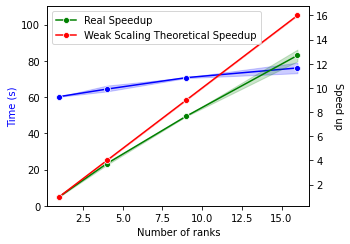

In [118]:
fig,ax0 = plt.subplots(figsize = (5,3.5))
ax1 = ax0.twinx()
sns.lineplot(data = df_summary, 
             x = 'number_of_ranks',
             y = 'time',
             marker = 'o',
             ax = ax0,
             color = 'blue')
ax0.set_ylim(0,110)
ax0.set_ylabel('Time (s)', color = 'blue')
ax0.set_xlabel('Number of ranks')

sns.lineplot(data = df_summary, 
             x = 'number_of_ranks',
             y = 'real_Sp',
             marker = 'o',
             ax = ax1,
             color = 'green',
             label = 'Real Speedup',)
sns.lineplot(data = df_summary, 
             x = 'number_of_ranks',
             y = 'theoretical_Sp',
             marker = 'o',
             ax = ax1,
             color = 'red',
             label = 'Weak Scaling Theoretical Speedup')
ax1.set_ylabel('Speed up', rotation = -90)
ax1.yaxis.set_label_coords(1.13, .5)

plt.tight_layout()
plt.savefig('weak_N350.png',dpi=300)

## 2. Parallelization with OpenMP threads - strong scaling 



sbatch script Settings:

#SBATCH --nodes=1

#SBATCH --tasks=1

#SBATCH --cpus-per-task=18

threads=(1 1 1 4 4 4 12 12 12 20 20 20 28 28 28 )

ranks=(1)

In [136]:
with open('team13_check222858_threads_anqi.out', 'r') as f:
    data=f.read()
    
#segment the report into a list, each element is one run
seg_pattern = r'Job size N = 100.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n'
all_performance = re.findall(seg_pattern, data)

#Regex statistics
result_table=[]
for text in all_performance:
    for i, size in enumerate([100,350]):
        result_dict ={}
        result_dict['N'] = int(re.findall(r'Job size.*\n',text)[i][13:-1])
        result_dict['time'] = float(re.findall(r'real.*\n',text)[i][5])*60+float(re.findall(r'real.*\n',text)[i][7:-2])
        result_dict['number_of_ranks'] = float(re.findall(r'Program completed with.*ranks',text)[0][23:-6])
        result_dict['number_of_threads'] = float(re.findall(r'ranks.*threads',text)[0][7:-8])
        result_table.append(result_dict)
    
df_summary=pd.DataFrame(result_table)

df_summary = df_summary[df_summary['N'] == 350]
#df_summary = df_summary[df_summary['N'] == 100]

# Calculate speedup


total = 66.821
parallel_portion = 66.375
sequential_portion = total - parallel_portion
f = sequential_portion/total
print(f)

time1 = df_summary[df_summary['number_of_threads'] == 1].time.mean()
df_summary['theoretical_Sp'] = 1/(f + (1-f)/df_summary['number_of_threads'])
df_summary['real_Sp'] = time1/df_summary['time']


0.006674548420406728


In [ ]:
df_summary.groupby(by = ['number_of_ranks', 'number_of_threads']).mean()

N       time  theoretical_Sp    real_Sp
number_of_ranks number_of_threads                                             
1.0             1.0                350.0  60.336333        1.000000   1.000001
                4.0                350.0  17.567000        3.921478   3.434659
                8.0                350.0  10.386000        7.642909   5.809908
                12.0               350.0   7.793333       11.179221   7.745339
                20.0               350.0   5.860333       17.749120  10.296586
                28.0               350.0   5.660000       23.724535  10.688667

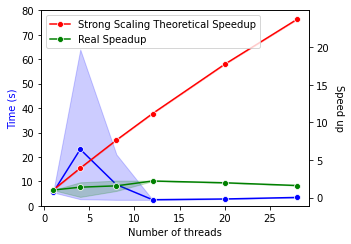

In [120]:

fig,ax0 = plt.subplots(figsize = (5,3.5))

ax1 = ax0.twinx()
sns.lineplot(data = df_summary, 
             x = 'number_of_threads',
             y = 'time',
             
             marker = 'o',
             ax = ax0,
             color = 'blue')
ax0.set_ylim(0,80)
ax0.set_ylabel('Time (s)', color = 'blue')
ax0.set_xlabel('Number of threads')

sns.lineplot(data = df_summary, 
             x = 'number_of_threads',
             y = 'theoretical_Sp',
             marker = 'o',
             ax = ax1,
             color = 'red',
             label = 'Strong Scaling Theoretical Speedup')


sns.lineplot(data = df_summary, 
             x = 'number_of_threads',
             y = 'real_Sp',
             marker = 'o',
             ax = ax1,
             color = 'green',
             label = 'Real Speadup'
             )

ax1.set_ylabel('Speed up', rotation = -90)
ax1.yaxis.set_label_coords(1.13, .5)

plt.tight_layout()
plt.savefig('strong_N350.png', dpi=300)

## Thread + rank


sbatch script Settings:

#SBATCH --nodes=1

#SBATCH --tasks=4

#SBATCH --cpus-per-task=7

threads=(1 1 1 3 3 3 5 5 5 7 7 7)

ranks=(1 4)

In [133]:
with open('team13_check223179_both_anqi.out', 'r') as f:
    data=f.read()

#segment the report into a list, each element is one run
seg_pattern = r'Job size N = 100.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n'
all_performance = re.findall(seg_pattern, data)

#Regex statistics
result_table=[]
for text in all_performance:
    for i, size in enumerate([100,350]):
        result_dict ={}
        result_dict['N'] = int(re.findall(r'Job size.*\n',text)[i][13:-1])
        result_dict['time'] = float(re.findall(r'real.*\n',text)[i][5])*60+float(re.findall(r'real.*\n',text)[i][7:-2])
        result_dict['number_of_ranks'] = float(re.findall(r'Program completed with.*ranks',text)[0][23:-6])
        result_dict['number_of_threads'] = float(re.findall(r'ranks.*threads',text)[0][7:-8])
        result_table.append(result_dict)
    
df_summary=pd.DataFrame(result_table)

df_summary = df_summary[df_summary['N'] == 350]

# Calculate speedup
#time1 = df_summary[df_summary['number_of_threads'] == 1].time.mean()
average_time1 = df_summary[df_summary['number_of_threads'] == 1].groupby(by = 'number_of_ranks').mean()[['time']]
average_time1.columns = ['average_time1']
df_summary = pd.merge(df_summary, average_time1, how = 'inner', on = 'number_of_ranks')

#df_summary['theoretical_Sp'] = df_summary['number_of_ranks']

df_summary['real_Sp'] = df_summary['average_time1']/df_summary['time']





In [134]:
df_summary.groupby(by = ['number_of_ranks', 'number_of_threads']).mean()

N       time  average_time1   real_Sp
number_of_ranks number_of_threads                                           
1.0             1.0                350.0  60.248667      60.248667  1.000002
                2.0                350.0  33.681000      60.248667  1.796586
                3.0                350.0  23.768000      60.248667  2.535815
4.0             1.0                350.0  66.479667      66.479667  1.000841
                2.0                350.0  46.158667      66.479667  1.497389
                3.0                350.0  29.894000      66.479667  2.268557
9.0             1.0                350.0  77.001333      77.001333  1.002919
                2.0                350.0  37.687000      77.001333  2.043487
                3.0                350.0  25.963000      77.001333  2.965825

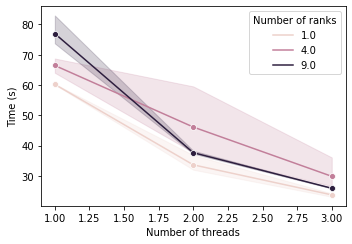

In [135]:
fig,ax0 = plt.subplots(figsize = (5,3.5))

sns.lineplot(data = df_summary, 
             x = 'number_of_threads',
             y = 'time',
             hue = 'number_of_ranks',
             marker = 'o',
             ax = ax0,
             color = 'blue')

ax0.set_ylabel('Time (s)')
ax0.set_xlabel('Number of threads')

plt.legend(title='Number of ranks')


plt.tight_layout()
plt.savefig('hybrid_N100.png')

## 3. Roofline calculation